## Introduction to the Project
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the "Join Competition button to create an account and gain access to the competition data. Then check out Alexis Cook’s Titanic Tutorial that walks you through step by step how to make your first submission!

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.


### Refrences You Might Wanna Have a Look at
Source: [Kaggle](https://www.kaggle.com/competitions/titanic)


Planning Notebook: [Planning.ipynb](https://github.com/muhammadanas0716/Machine-Learning-Projects-101/blob/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/Planning....ipynb)

In [1]:
# Importing all the needed libraries

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Analysis and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Some Extras
import xgboost as xgb

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

Done Importing!

## Feature Extraction
Meaning that clean up the present features in our dataset, like the `Name` column and the `Ticket` Columns...

In [2]:
# Loading the data
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Shape of the dataset
print(f"""Columns: {titanic_df.shape[1]}
Rows: {titanic_df.shape[0]}""")

Columns: 12
Rows: 891


In [4]:
# Null Values
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Umm....well I don't think Cabin is very useful here. As more than 90% values are missing. Regarding age, we'll just fill it with the **mean**. And the 2 values regarding Embarked, we can just fill in **S** as this is the majority of the embarkments.

In [5]:
# Removing Cabin Column
titanic_df.drop("PassengerId", axis=1, inplace=True)
titanic_df.drop("Cabin", axis=1, inplace=True)


# Filling the age column with the mean age
titanic_df["Age"].fillna(titanic_df["Age"].mean(), inplace=True)

# Filling in the Embarked column with S (i.e Southampton) as majority value is Southampton
titanic_df["Embarked"].fillna("S", inplace=True)

Column **SibSp** and **Parch** can be combined into a `FamilyMembers` Column..

In [6]:
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"]

# Dropping the SibSp and Parch columns
titanic_df.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [7]:
titanic_df["FamilySize"].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

Oh, there are 10 numbers, let's try and reduce these 10 values to 4.

In [8]:
titanic_df['FamilySize'] = pd.cut(titanic_df['FamilySize'],
                                     bins=[0,1,4,7,100], 
                                     labels=['Alone','Small','Medium','Large'],
                                     right=False)
titanic_df["FamilySize"].value_counts()

Alone     537
Small     292
Medium     49
Large      13
Name: FamilySize, dtype: int64

#### Ticket Type

As of now, we are unsure as to what type of information we are expecting. So we will start by just exploring the ticket column and what kind of data it holds.

In [9]:
titanic_df["Ticket"].value_counts

<bound method IndexOpsMixin.value_counts of 0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object>

In [10]:
titanic_df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [11]:
titanic_df['Ticket'] = titanic_df['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else '0')

In [12]:
titanic_df["Ticket"].unique()

array(['A/5', 'PC', 'STON/O2.', '0', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

From the above list we can see all the ticket types existing in the dataset. Observing the names of the tickets we can see that they represent a location; probably a pair of boarding and destination points but we are not sure. Later in the EDA section we'll see what information this column can give us.

Since the number of data for all these codes is not sufficient, it may not be a good idea to consider them in the current form. Instead, we will group the ticket type by using just the initials of the ticket code.

In [13]:
titanic_df['Ticket'] = titanic_df['Ticket'].apply(lambda x: x[0])
titanic_df["Ticket"].value_counts()

0    665
P     65
S     65
C     47
A     29
W     13
F      7
Name: Ticket, dtype: int64

Now we have 7 groups of ticket type but we still have less data in A, W and F types. Let's group them together and create a single type named AFW...this just to make things a bit easier.

In [14]:
titanic_df['Ticket'] = titanic_df['Ticket'].apply(lambda x: 'AFW' if x in 'AFW' else x)

In [15]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,AFW,7.2500,S,Small
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,P,71.2833,C,Small
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S,7.9250,S,Alone
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,0,53.1000,S,Small
4,0,3,"Allen, Mr. William Henry",male,35.0,0,8.0500,S,Alone


#### Name 
The name column seems pretty useless, so let's just extract some info from it, like the the titles.

In [16]:
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Oh well, the first 4 are of some significance, so let's enjoin them as below.

In [17]:
titanic_df["Title"] = titanic_df["Title"].replace(["Mme", "Ms", "Lady", "Mlle", "the Countess"],
                                                  ["Mrs", "Miss", "Mrs", "Mrs", "Mrs"])

titanic_df["Title"] = titanic_df["Title"].replace(["Don", "Rev", "Dr", "Major", "Sir", "Col", "Capt", "Jonkheer"], 
                                                  "Mr")

In [18]:
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [19]:
titanic_df.drop("Name", axis=1, inplace=True)

In [20]:
# Change the type of these columns - just to remove decimals
titanic_df["Age"] = titanic_df["Age"].astype(np.int64)
titanic_df["Fare"] = titanic_df["Fare"].astype(np.int64)

In [21]:
# Re-arange the columns
titanic_df = titanic_df.reindex(columns=["Survived", "Title", "Pclass", "Sex", "Age","FamilySize", "Fare", "Ticket", "Embarked"])

### Let's do the EDA now
## Exploratory Data Analysis (EDA)
0. Most Correlated values
1. Value counts of the numeric columns
2. Frequencies Plotting (PLOTTING OF ABOVE POINT)
3. This FEATURE VS this FEATURE
4. Any Null values

In [22]:
titanic_df

,Survived,Title,Pclass,Sex,Age,FamilySize,Fare,Ticket,Embarked
0,0,Mr,3,male,22,Small,7,AFW,S
1,1,Mrs,1,female,38,Small,71,P,C
2,1,Miss,3,female,26,Alone,7,S,S
3,1,Mrs,1,female,35,Small,53,0,S
4,0,Mr,3,male,35,Alone,8,0,S
...,...,...,...,...,...,...,...,...,...
886,0,Mr,2,male,27,Alone,13,0,S
887,1,Miss,1,female,19,Alone,30,0,S
888,0,Miss,3,female,29,Small,23,AFW,S
889,1,Mr,1,male,26,Alone,30,0,C


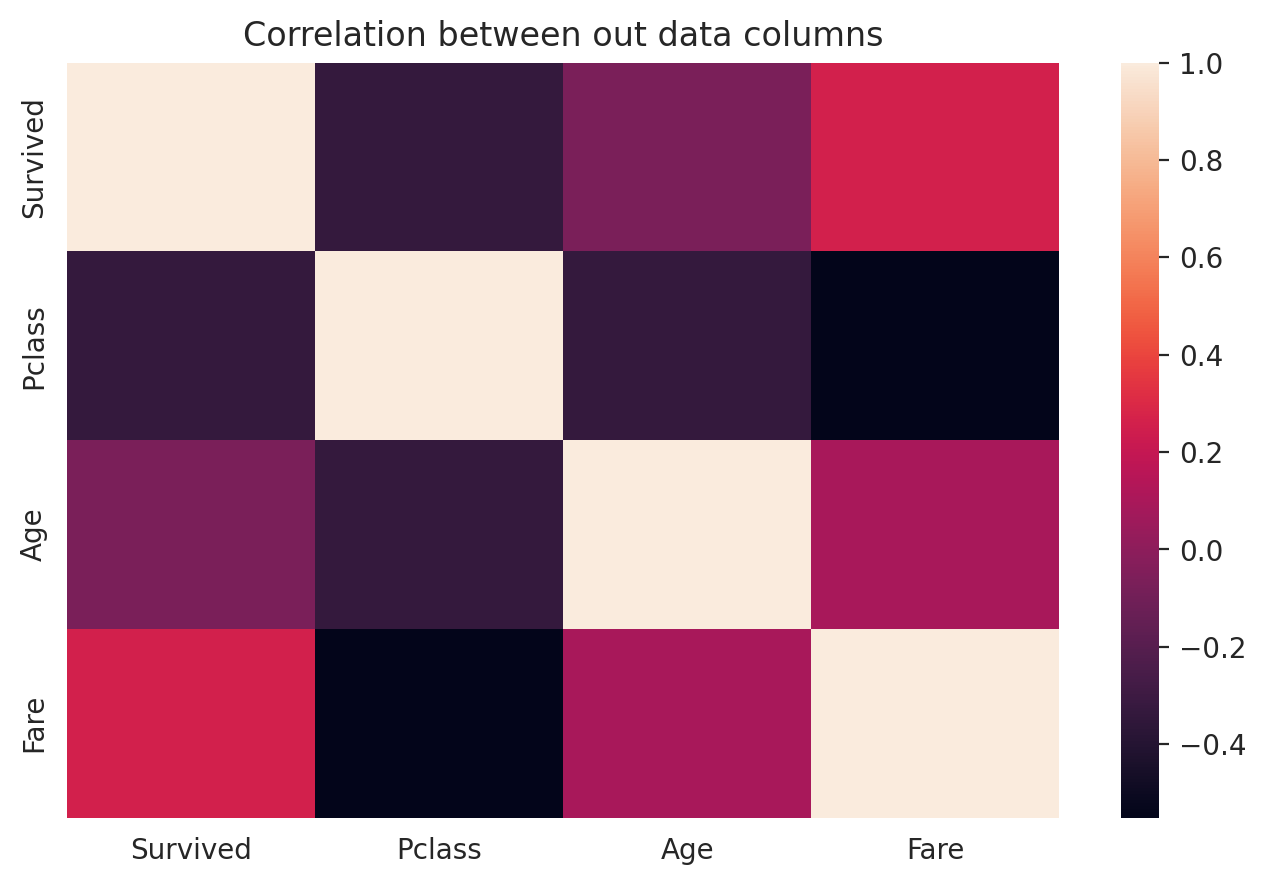

In [23]:
plt.figure(figsize=(8, 5), dpi=200)
titanic_df_corr = titanic_df.corr()
sns.heatmap(titanic_df_corr)

plt.title("Correlation between out data columns")
plt.show()

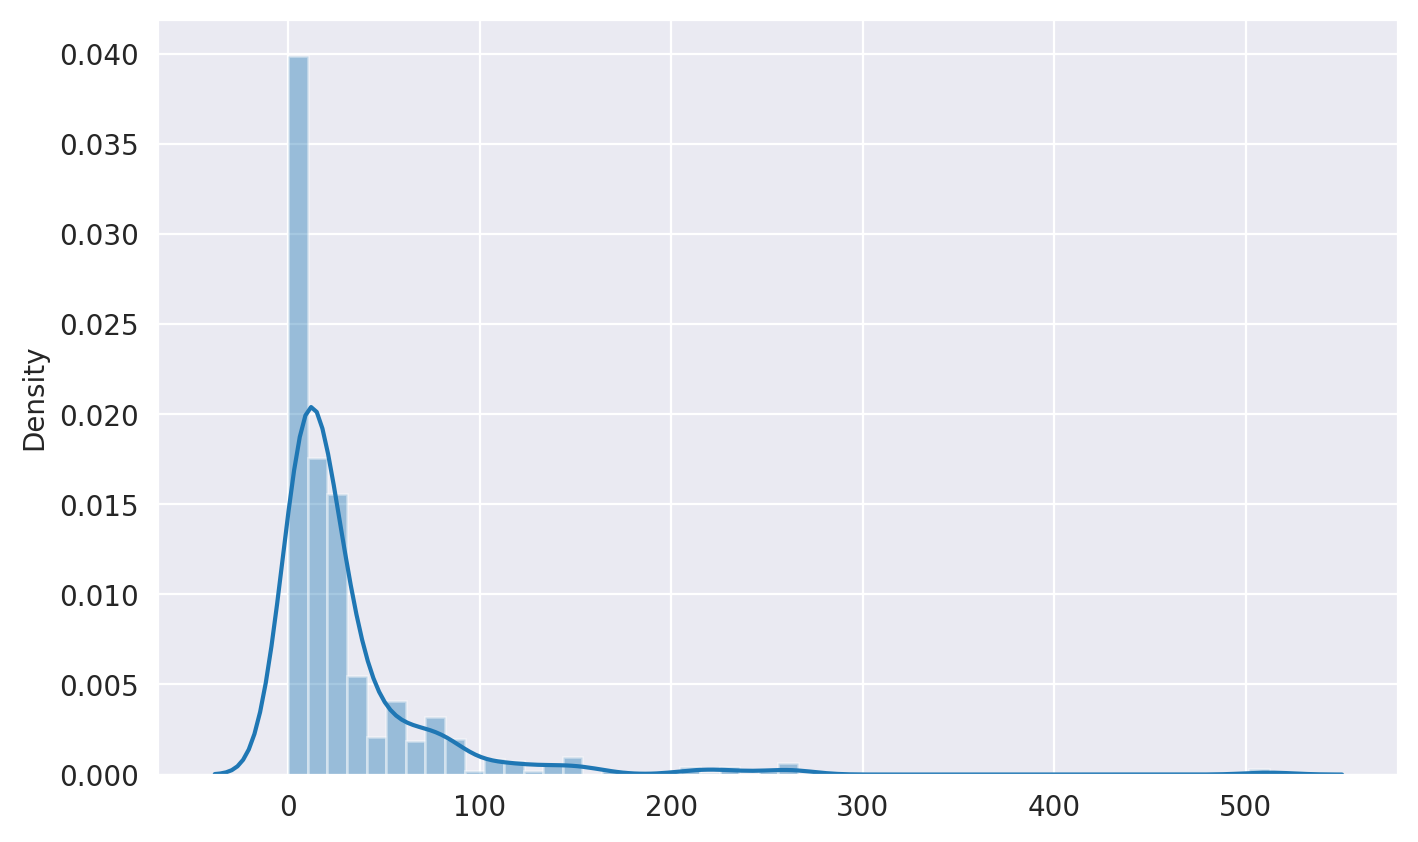

In [24]:
# Distribution of the Fares
plt.figure(figsize=(8, 5), dpi=200)
sns.distplot(x=titanic_df["Fare"])
plt.show()

Well, most of the prices are between 10-80.

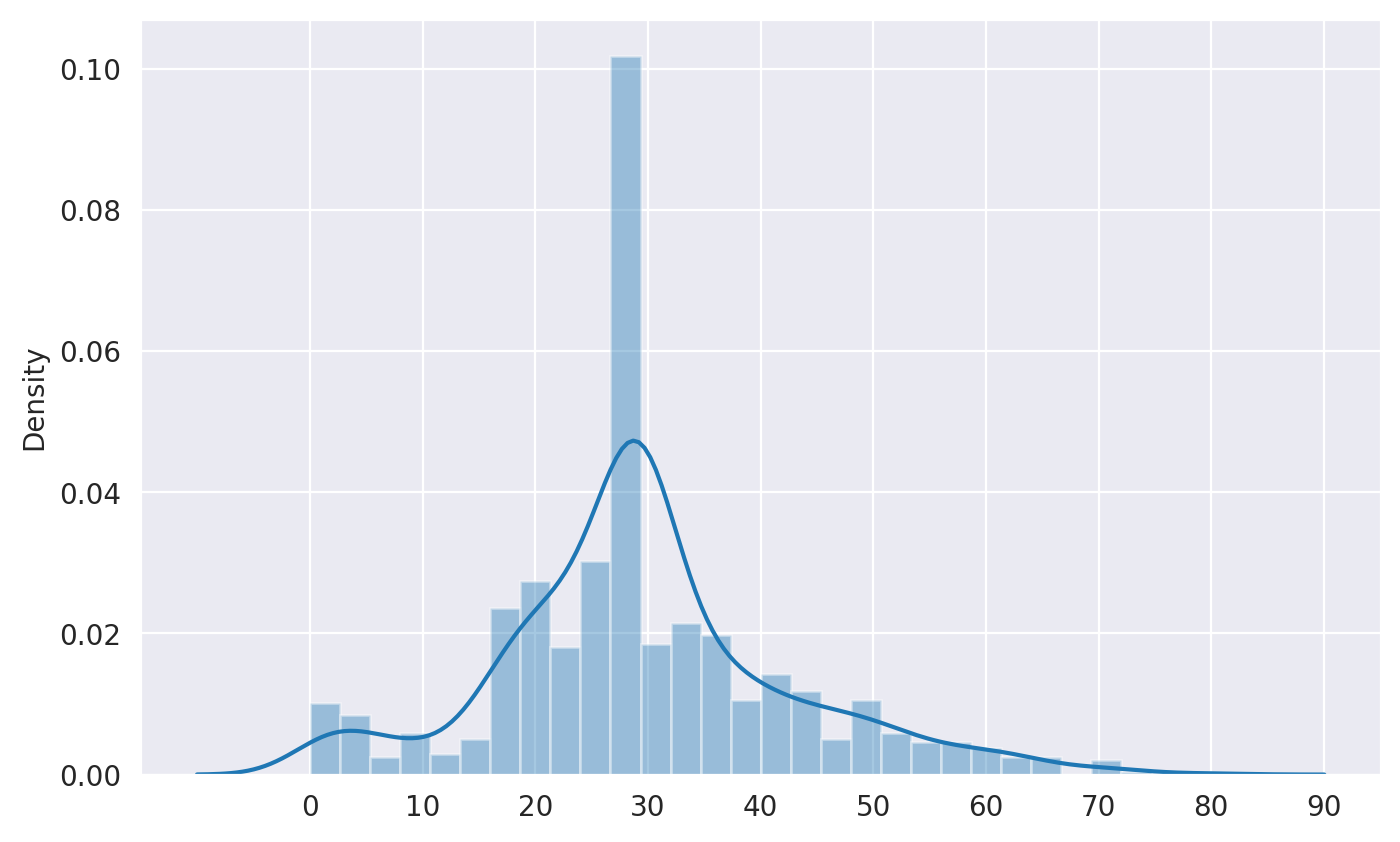

In [25]:
# Distribution of age
plt.figure(figsize=(8, 5), dpi=200)
sns.distplot(x=titanic_df["Age"])
plt.xticks(np.arange(0, 100, 10))
plt.show()

Most poeple on board, seem to be young adults, between the age of 20-40. It could be just me but from what the histogram shows us, there seem to be a decent number of children as well!

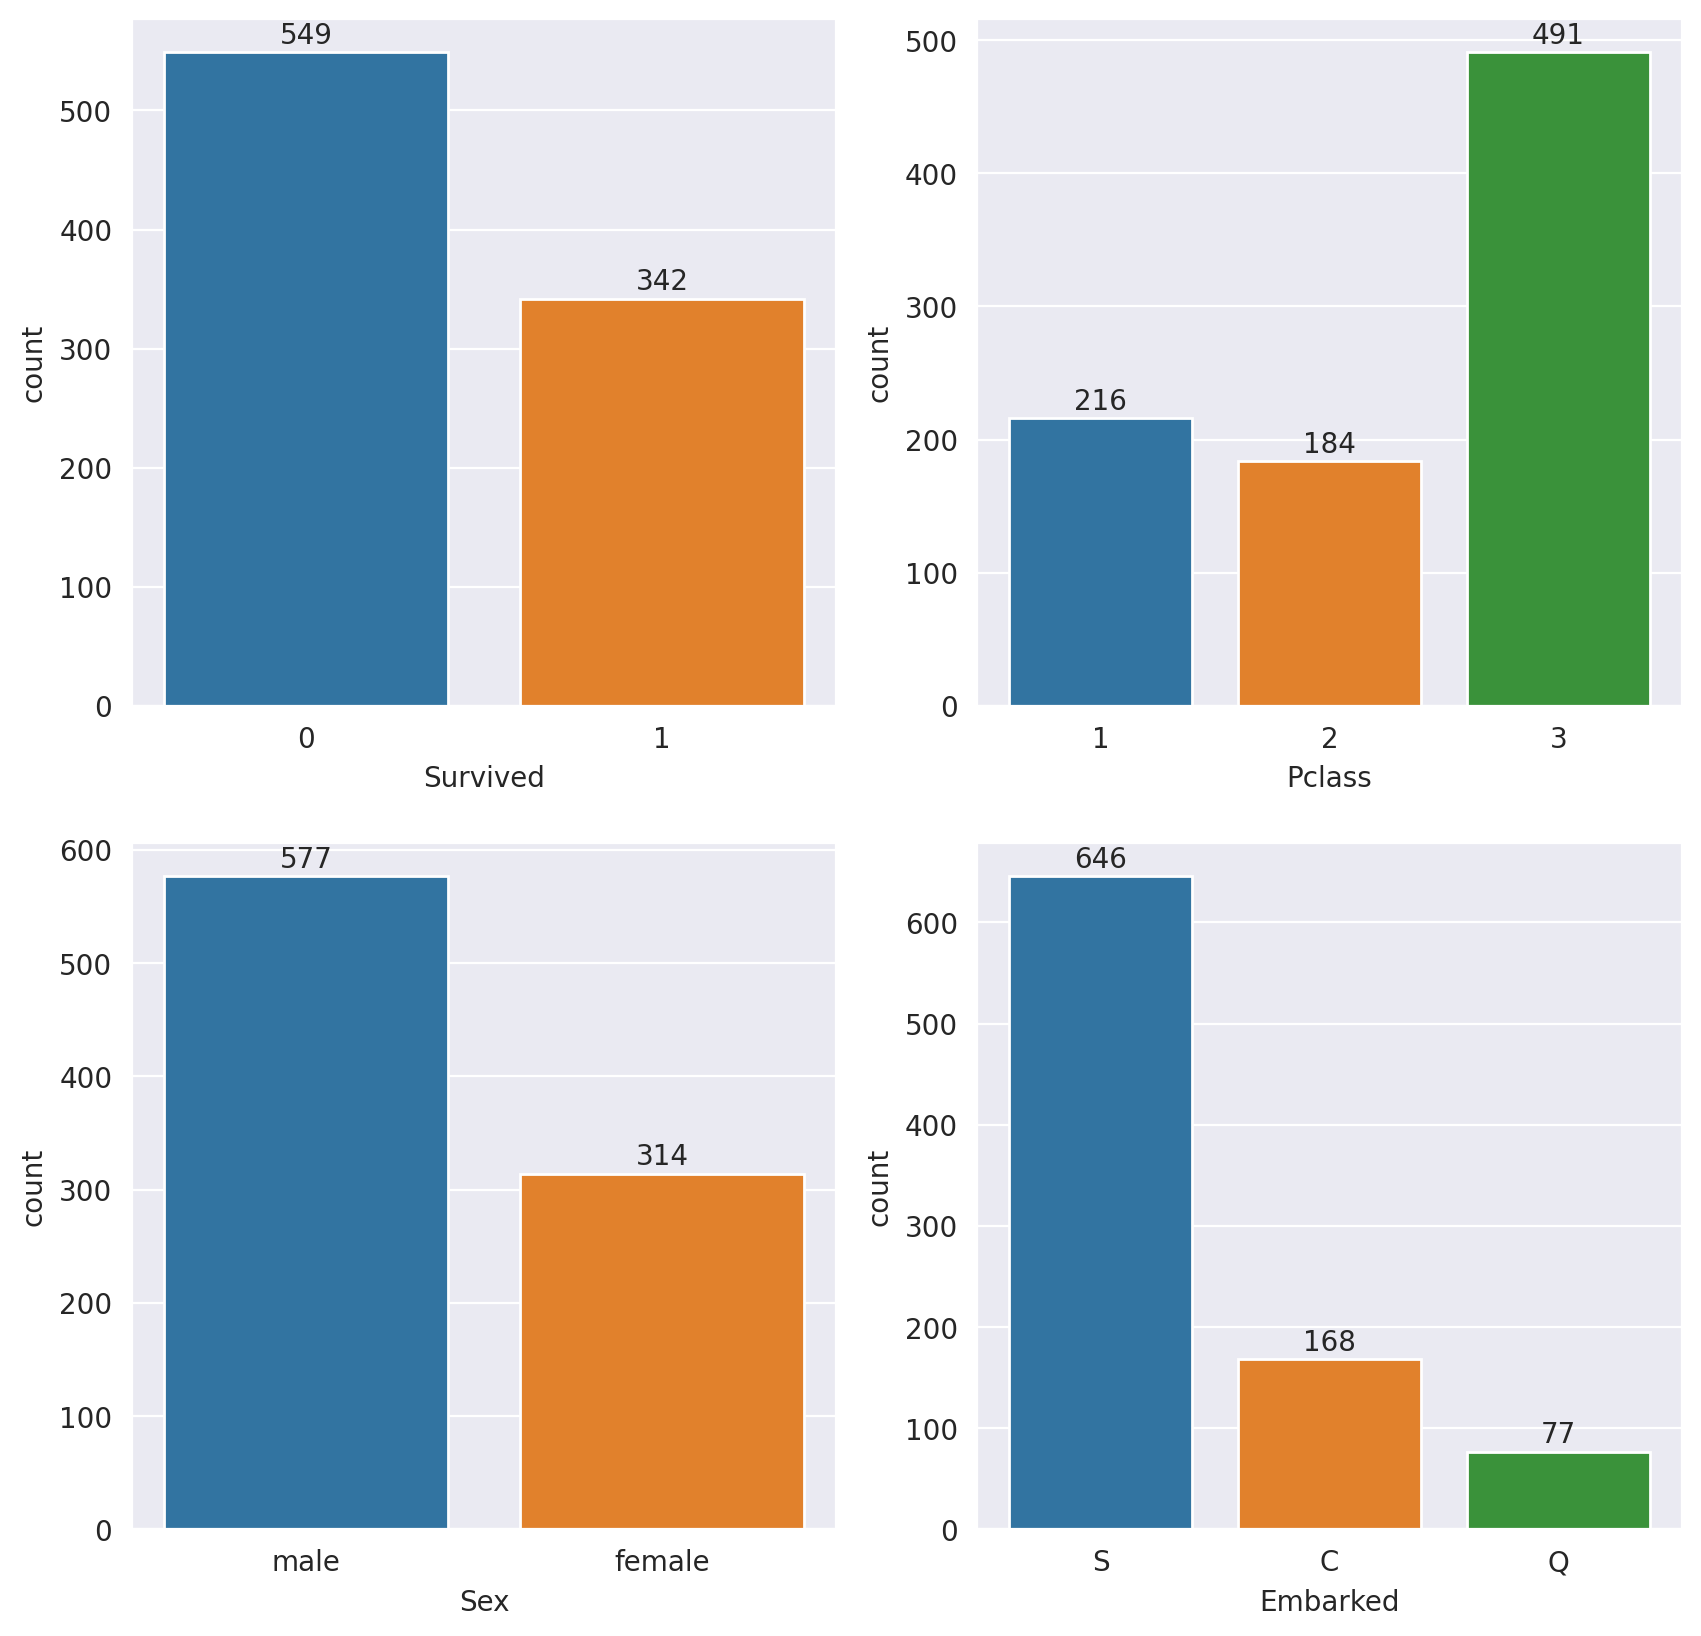

In [26]:
# Get the count of the needed columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
sns.countplot(data=titanic_df, x="Survived", ax=axes[0,0])
sns.countplot(data=titanic_df, x="Pclass", ax=axes[0, 1])
sns.countplot(data=titanic_df, x="Sex", ax=axes[1, 0])
sns.countplot(data=titanic_df, x="Embarked", ax=axes[1, 1])

for ax in axes.flat:
    ax.bar_label(ax.containers[0],label_type='edge', padding=1)
    ax.margins(x=0.05)
plt.show()

The above 4 plots show the count of some of the categories/features/columns I was interested in knowing about.

We can observe:
* In the first plot, most poeple seem to have died 😞
* In the second plot, majority of the population was in **Pclass** of 3 (i.e lower class)
* In the third plot, we can observe that most of the poeple on board were males (i.e 577)
* In the fourth plot, it's clear that most poeple embarked from Southampton and least from Queenstown

Why not some relational plots...

1. Sex VS. Survived
2. Pclass VS. Survived
3. FamilyMembers VS. Survived
4. Embarkment VS. Survived

**Note:** These are percentages...

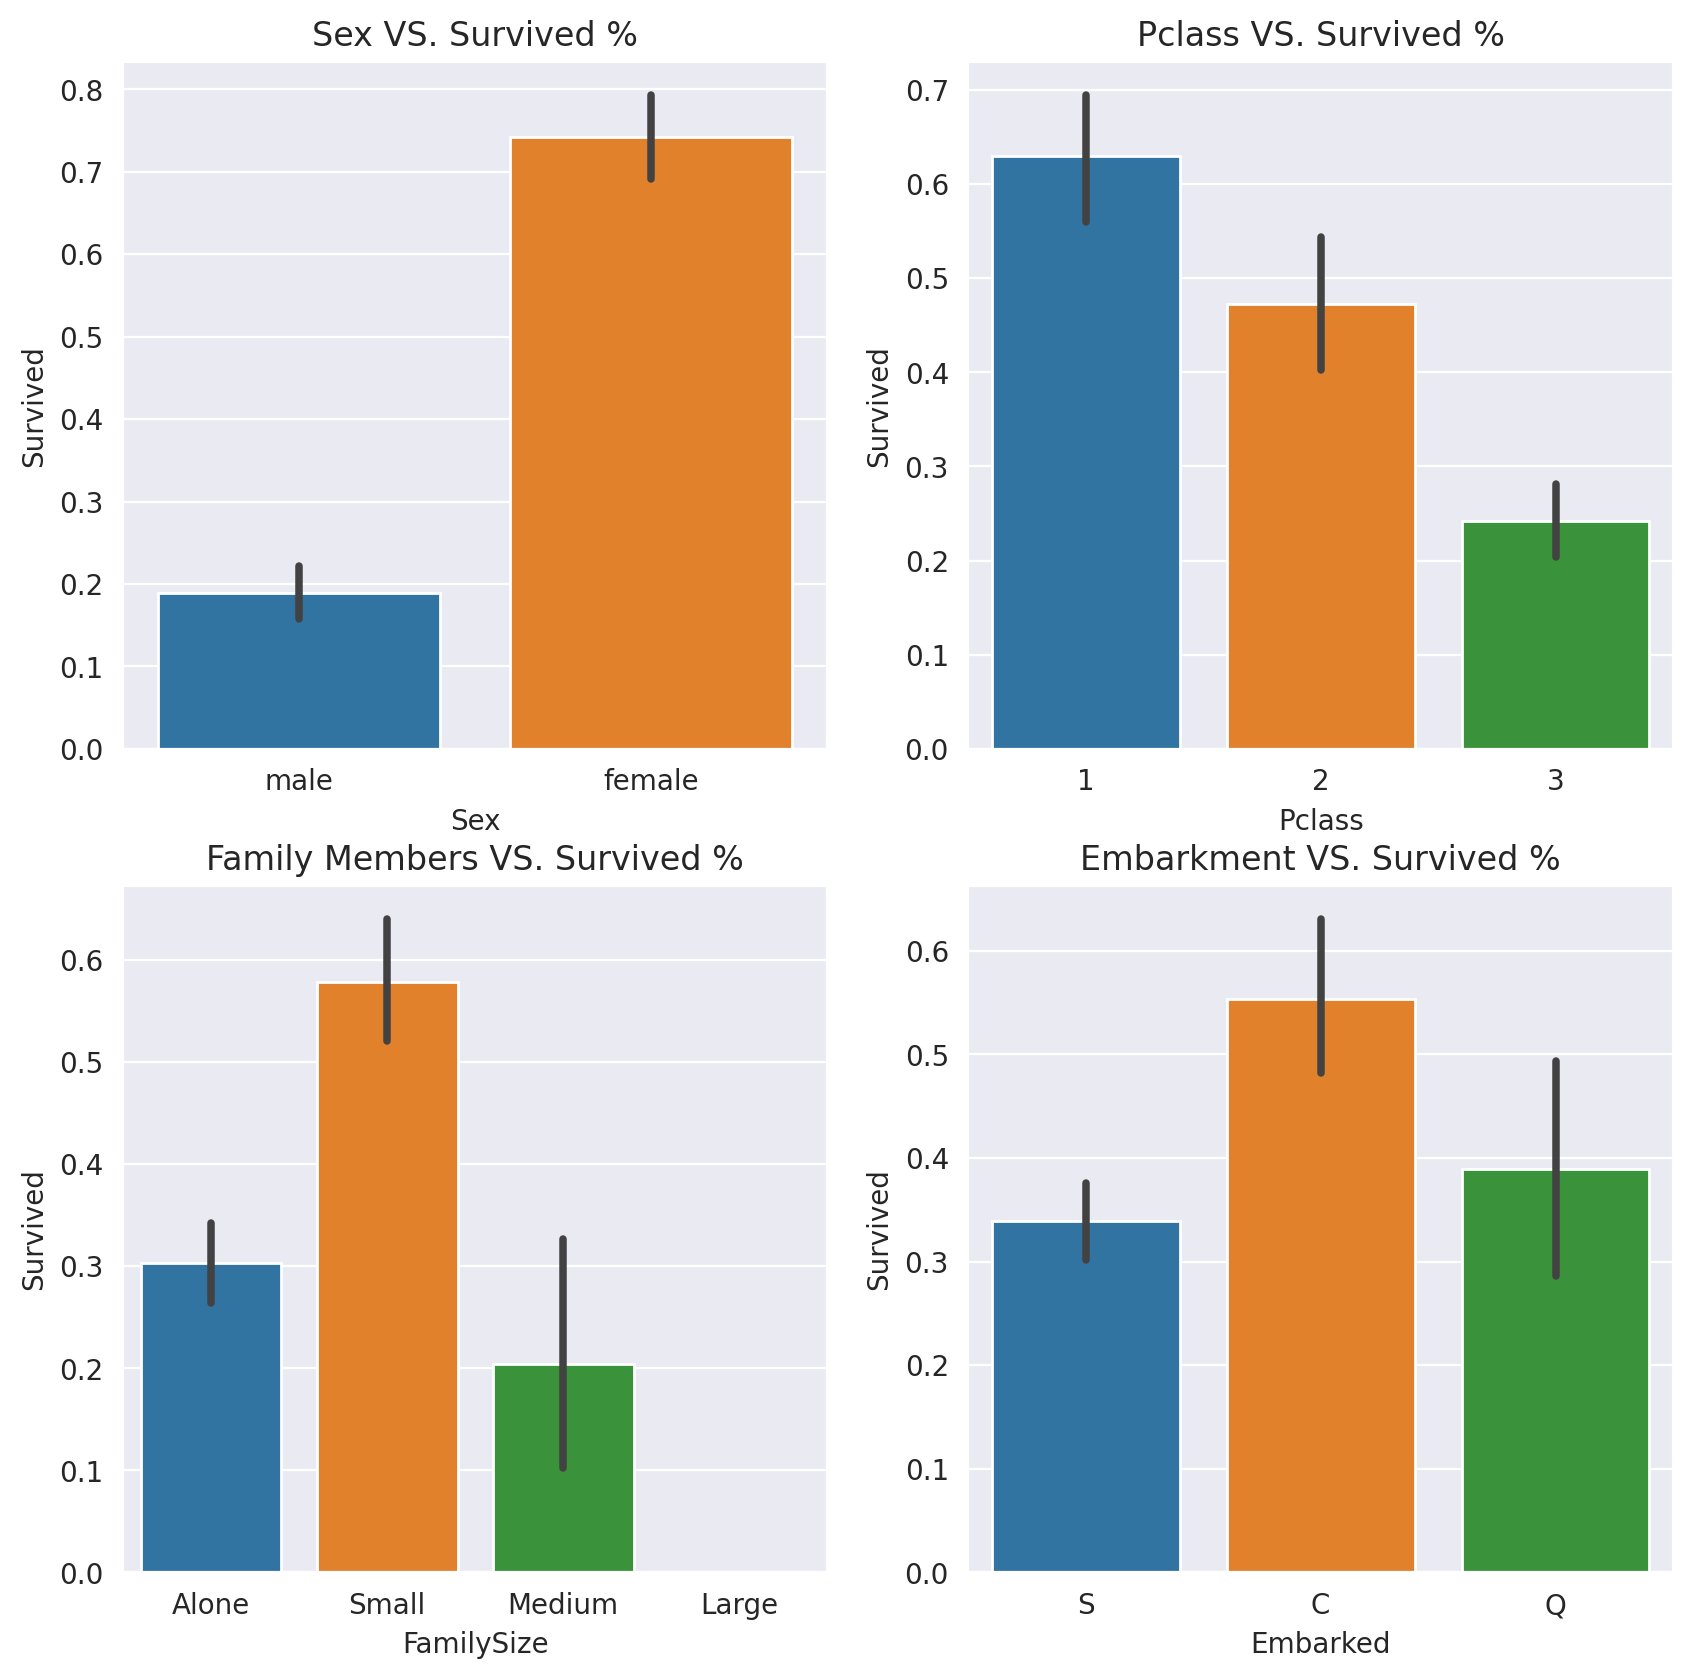

In [27]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

# Plot on 1st subplot
sns.barplot(data=titanic_df, x="Sex", y="Survived", ax=axes[0, 0]).set(title="Sex VS. Survived %")
sns.barplot(data=titanic_df, x="Pclass", y="Survived", ax=axes[0, 1]).set(title="Pclass VS. Survived %")
sns.barplot(data=titanic_df, x="FamilySize", y="Survived", ax=axes[1, 0]).set(title="Family Members VS. Survived %")
sns.barplot(data=titanic_df, x="Embarked", y="Survived", ax=axes[1, 1]).set(title="Embarkment VS. Survived %")


# Show
plt.show()

Let's get a bit more precise...

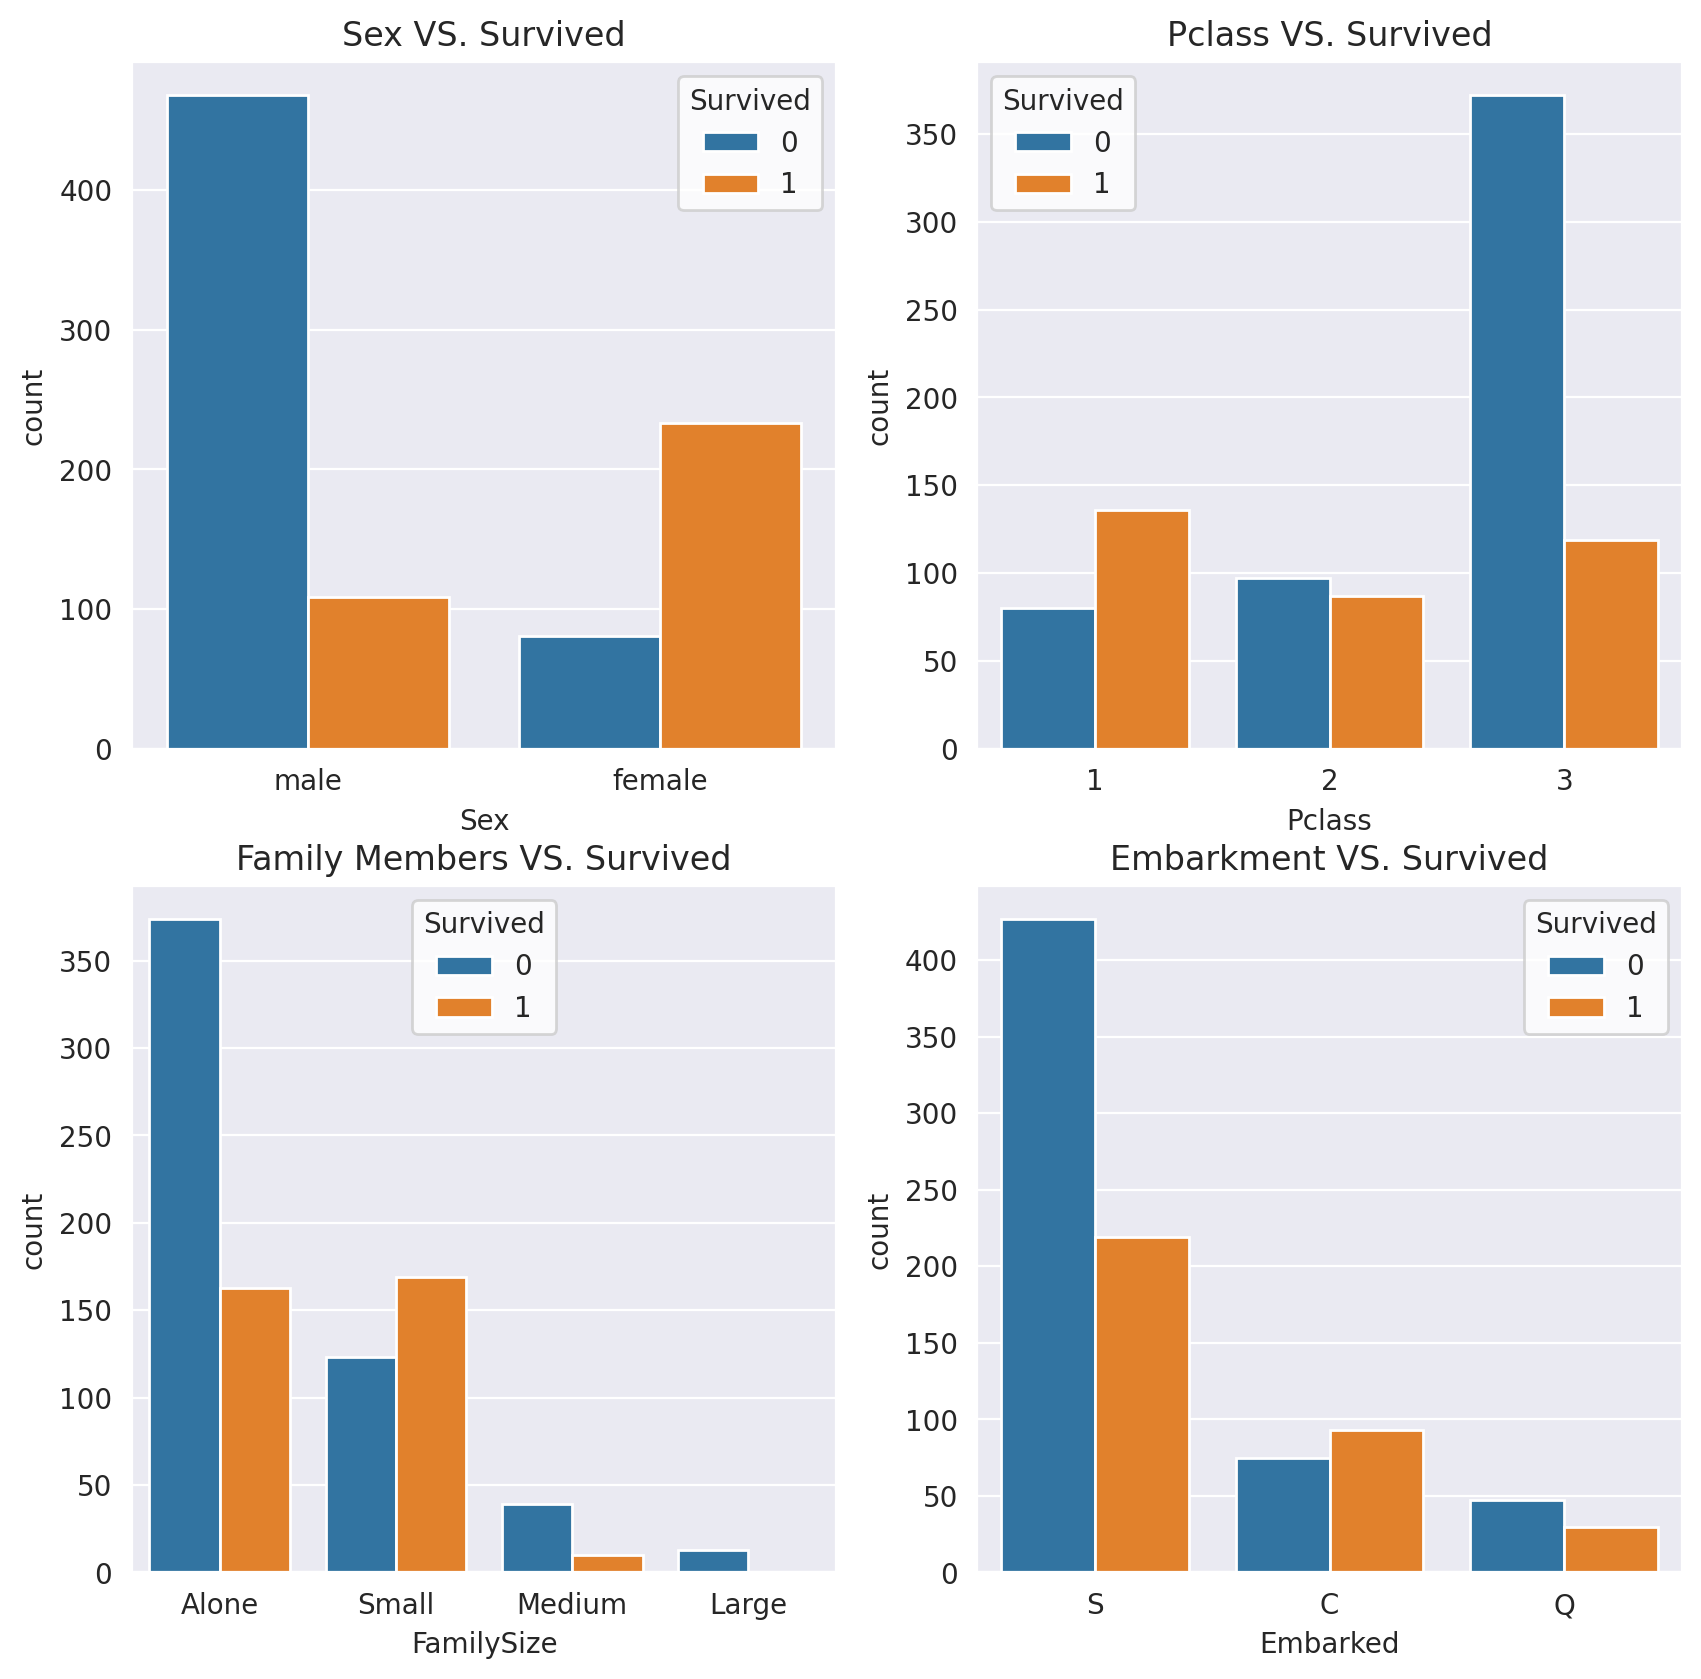

In [28]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
sns.set_style("whitegrid")

# Plot on 1st subplot
sns.countplot(data=titanic_df, x="Sex", hue="Survived", ax=axes[0, 0]).set(title="Sex VS. Survived")
sns.countplot(data=titanic_df, x="Pclass", hue="Survived", ax=axes[0, 1]).set(title="Pclass VS. Survived")
sns.countplot(data=titanic_df, x="FamilySize", hue="Survived", ax=axes[1, 0]).set(title="Family Members VS. Survived")
sns.countplot(data=titanic_df, x="Embarked", hue="Survived", ax=axes[1, 1]).set(title="Embarkment VS. Survived")


# Show
plt.show()

Okay, we can clearly obesrve the following:
1. **First Plot**
    * `MALES`
        * Around 470 males have seemed to doomed
        * Around 110 males seems to have survived
    
    * `FEMALES`
        * Around 90 females seem to have perished
        * Amazingly over 220 females survived the ordeal
        
2. **Second Plot**
    * `1st Class`
        * Around 75 died
        * And approximately 160 survived
    
    * `2nd Class`
        * Around 90 poeple died
        * However over 80 perished
        
    * `3rd Class`
        * Majority died (i.e 370)
        * Around 110 survived
3. **Third Plot**
    * Mostly poeple survived in the small group, and unfortunately least in the large group
    * Most poeple died who were alone, over 400...sad right?
    
4. **Fourth Plot**
    * Most poeple died who departed from the Southampton port. Also most of the poeple who were on board the Titanic were ported on Southampton.
    * Least were from Cherbourg
     

Now let's explore the 2 columns we created, `Title` & `Ticket`

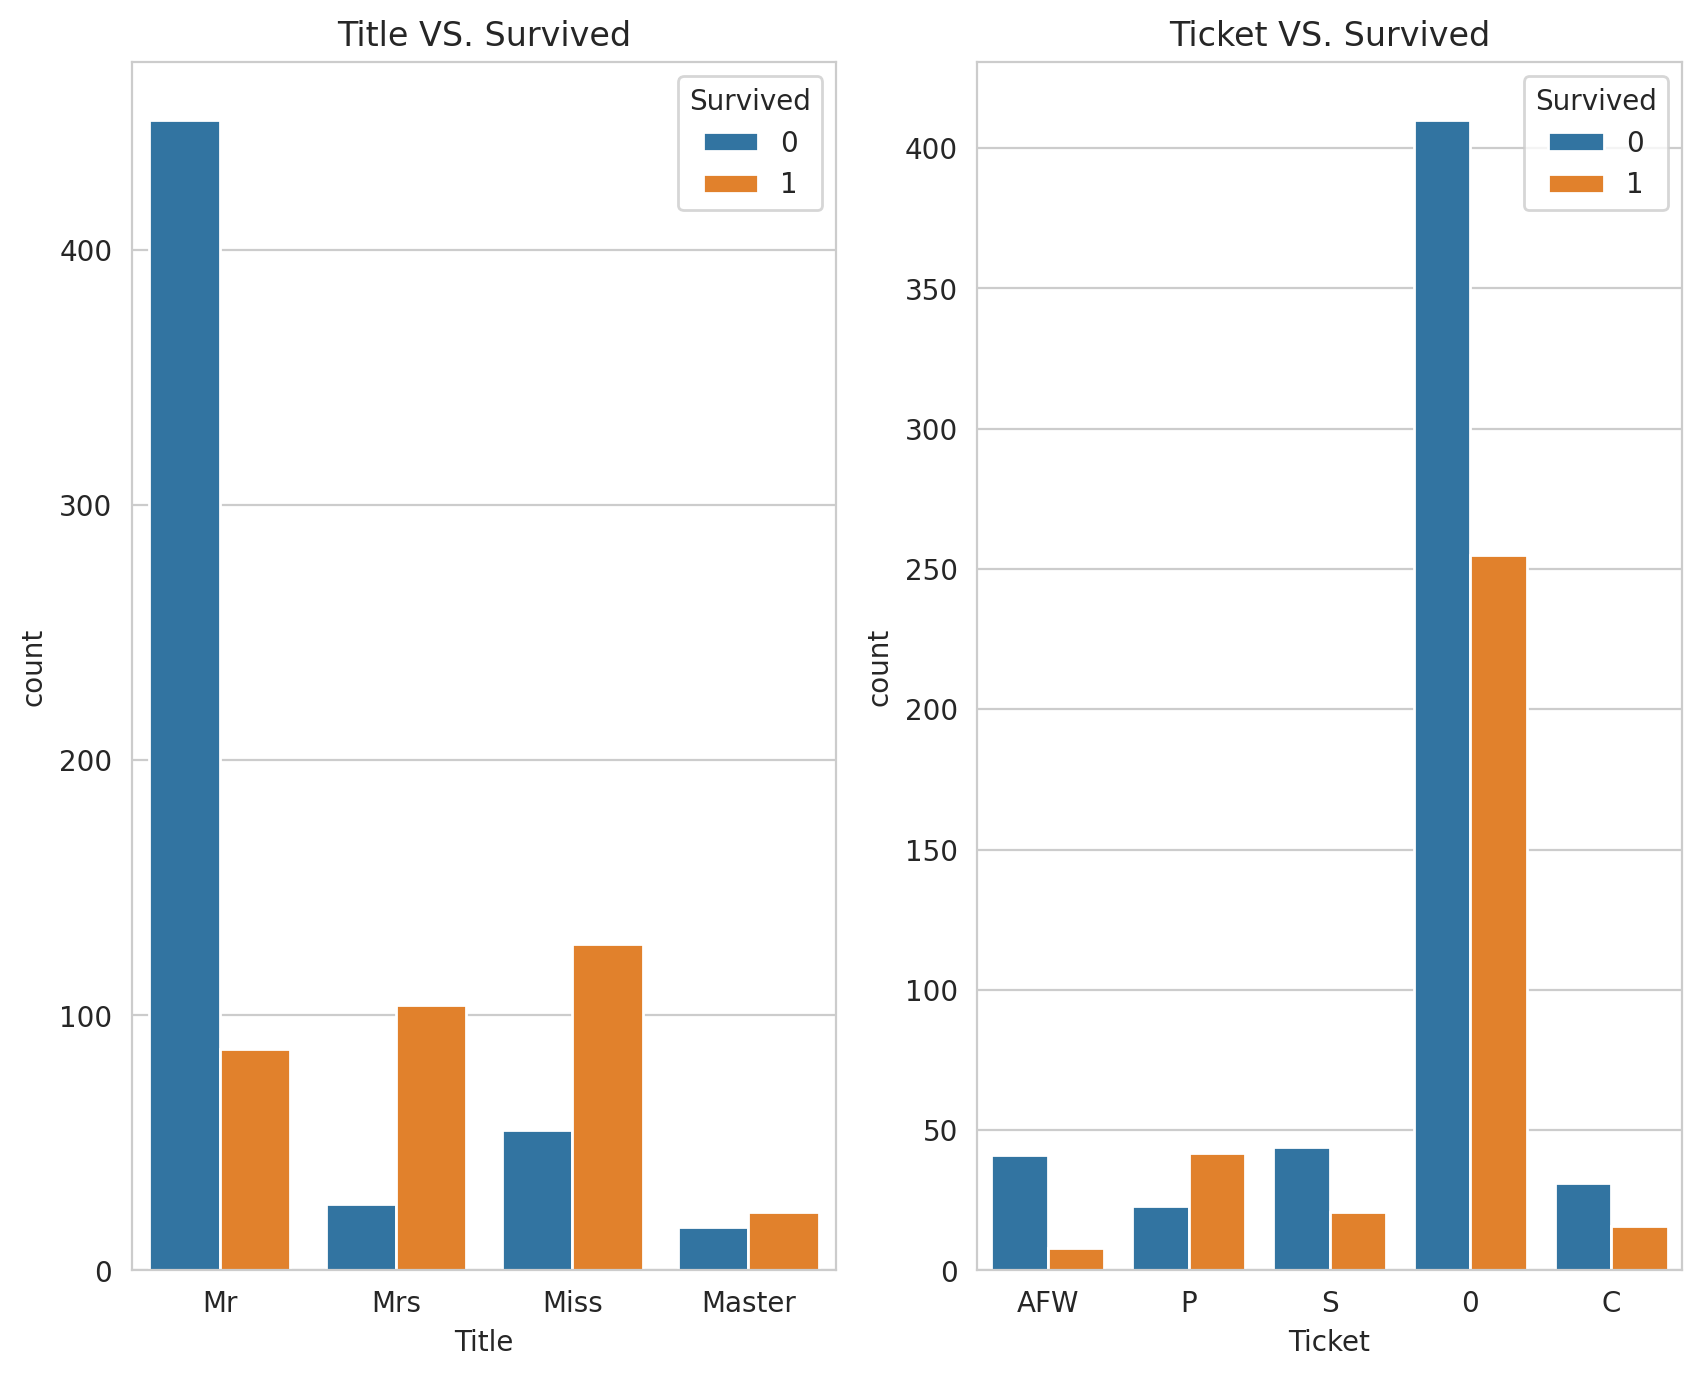

In [29]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8), dpi=200)

# Plot on 1st subplot
sns.countplot(data=titanic_df, x="Title", hue="Survived", ax=axes[0]).set(title="Title VS. Survived")
sns.countplot(data=titanic_df, x="Ticket", hue="Survived", ax=axes[1]).set(title="Ticket VS. Survived")


# Show
plt.show()

Enough EDA! Let's get to the fun bit - Machine Learning

But before we start testing out chosen ML models, we should convert our dataset into numbers...**OneHotEncoding**

## Modelling

Before we do anything else, let's import the test sets and do the neccary changes

In [30]:
titanic_df_test = pd.read_csv("test.csv")
titanic_df_submissions = pd.read_csv("gender_submission.csv")

In [31]:
# Do all what we did the test set.

# 1. Filling and Changing the columns
titanic_df_test["Age"].fillna(titanic_df_test["Age"].mean(), inplace=True)
titanic_df_test["Embarked"].fillna("S", inplace=True)
titanic_df_test["Fare"].fillna(titanic_df_test["Fare"].mean(), inplace=True)

# 2. Creating Columns
titanic_df_test["FamilySize"] = titanic_df_test["SibSp"] + titanic_df_test["Parch"]
titanic_df_test['FamilySize'] = pd.cut(titanic_df_test['FamilySize'],
                                     bins=[0,1,4,7,100], 
                                     labels=['Alone','Small','Medium','Large'],
                                     right=False)
titanic_df_test["FamilySize"].value_counts()
titanic_df_test['Ticket'] = titanic_df_test['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else '0')
titanic_df_test['Ticket'] = titanic_df_test['Ticket'].apply(lambda x: x[0])
titanic_df_test['Ticket'] = titanic_df_test['Ticket'].apply(lambda x: 'AFW' if x in 'AFW' else x)
titanic_df_test['Title'] = titanic_df_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic_df_test["Title"] = titanic_df_test["Title"].replace(["Mme", "Ms", "Lady", "Mlle", "the Countess"],
                                                  ["Mrs", "Miss", "Mrs", "Mrs", "Mrs"])

titanic_df_test["Title"] = titanic_df_test["Title"].replace(["Don", "Rev", "Dr", "Major", "Sir", "Col", "Capt", "Jonkheer"], 
                                                  "Mr")

# 3. Dropping Columns
titanic_df_test.drop("PassengerId", axis=1, inplace=True)
titanic_df_test.drop("Cabin", axis=1, inplace=True)
titanic_df_test.drop("Name", axis=1, inplace=True)

# 4. Type Casting
titanic_df_test["Age"].astype("int")
titanic_df_test["Fare"].astype("int")

# 5. Re Arange columns
titanic_df_test = titanic_df_test.reindex(columns=["Title", "Pclass", "Sex", "Age","FamilySize", "Fare", "Ticket", "Embarked"])

In [32]:
# Converting the columns to numbers

# Dictionaries
title = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4}
sex = {"male": 1,"female": 2}
familysize = {"Alone" : 1, "Small" : 2, "Medium": 3, "Large" : 4}
ticket = {"0" : 1, "P" : 2, "S" : 3, "AFW" : 4, "C" : 5}
embarkment = {"S" : 1, "C" : 2, "Q" : 3}

# Convert
titanic_df["Title"] = [title[item] for item in titanic_df["Title"]]
titanic_df["Sex"] = [sex[item] for item in titanic_df["Sex"]]
titanic_df["FamilySize"] = [familysize[item] for item in titanic_df["FamilySize"]]
titanic_df["Ticket"] = [ticket[item] for item in titanic_df["Ticket"]]
titanic_df["Embarked"] = [embarkment[item] for item in titanic_df["Embarked"]]

In [33]:
# X and y sets
X_train = titanic_df.drop("Survived", axis=1)
y_train = titanic_df["Survived"]

In [34]:
X_train.head(3)

,Title,Pclass,Sex,Age,FamilySize,Fare,Ticket,Embarked
0,1,3,1,22,2,7,4,1
1,3,1,2,38,2,71,2,2
2,2,3,2,26,1,7,3,1


So we've converted the needed things to numbers and now we can move towards the fun part, which is trying it out different ML models!

(891, 8)